# Instructions: 
##### To just produce final graph(s) as seen in the paper, run cells in "Section 1: Setup" and "Section 3: Final Graph(s)" section only, ignore the "Section 2: Simulations "
##### To run the simulations and produce your own data, run the whole notebook

### Section 1: Setup

In [19]:
import msprime
import tskit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab
import scipy.linalg
import matplotlib
import csv
import random
from itertools import groupby
import collections
from scipy.special import gamma, factorial
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import curve_fit
###########################################

plt.style.use("seaborn-v0_8-white")
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['ytick.major.size'] = 10

##############################################
def migration_matrix_2d(length, migration_rate):
    result=[ [0]*length**2 for i in range(length**2)]
    for i in range(length**2):
        for j in range(length**2):
            #print(i)
            #left edge cases
            if i == 0:
                result[i][i+1]= migration_rate
                result[i][length]=migration_rate
            elif i==(length*(length-1)):
                result[i][i-length]= migration_rate
                result[i][i+1]=migration_rate
            elif i%length==0 :
                result[i][i-length]= migration_rate
                result[i][i+1]=migration_rate
                result[i][i+length]=migration_rate
                
            #right edge cases 
            elif i==length-1:
                result[i][i-1]=migration_rate
                result[i][i+length]=migration_rate
            elif i==(length**2-1):
                result[i][i-length]= migration_rate
                result[i][i-1]=migration_rate
            elif (i+1)%length==0 :
                result[i][i-length]= migration_rate
                result[i][i-1]=migration_rate
                result[i][i+length]=migration_rate
                
            
            #top and bottom edge cases
            elif 0< i <length-1:
                result[i][i-1]= migration_rate
                result[i][i+1]=migration_rate
                result[i][i+length]=migration_rate
            elif (length)*(length-1) < i < length**2-1:
                result[i][i-1]= migration_rate
                result[i][i+1]=migration_rate
                result[i][i-length]=migration_rate
                
            #inner nodes
            else:
                result[i][i-1]= migration_rate
                result[i][i+1]=migration_rate
                result[i][i-length]=migration_rate
                result[i][i+length]=migration_rate
                
                
                
                
                
            
    return result

##############################################################
Deme_density = 10
L = 900 #the number of demes 
deme_sample_size = Deme_density #deme sample size = 40
trials = 50 #number of trials
m=0.005
total_sample_size = int(L * deme_sample_size) # total sample size
matrix = migration_matrix_2d(int(np.sqrt(L)), m/4)


population_configurations = L * [msprime.PopulationConfiguration(deme_sample_size)]


print("1 >> ",m*Deme_density )

m_1=m/2
m_2=m/2
m_t=m_1+m_2
Effective_pop = (L)/(m_t)

real_pop = L*Deme_density


# Since we're using branch lengths, the mutation rate is 1
Theta_eff = 4 * Effective_pop
Theta_real = 4 * real_pop

transition_freq=max(Deme_density,(m*Deme_density**2))/total_sample_size


1 >>  0.05


### Section 2: Simulations 

#### Running coalescent simulations

In [ ]:
afs2 = []
for i in range(50):
    ts = msprime.simulate(Ne=Deme_density, population_configurations=population_configurations, migration_matrix=matrix,record_provenance=False);


    afs1 = ts.allele_frequency_spectrum(mode="branch", polarised=True, span_normalise=False);
    
    afs2.append(afs1);

    
    #print("iteration",i);
    #unhash above line if you want to track progress of simulation
    
afs = np.mean(afs2, 0)  

#### Setting up smoothing functions 

In [14]:
def smooth(x, threshold=100, rescale=2):
    return [np.mean(x[max(i - (rescale * i) // threshold, 0) : min(i + 1 + (rescale * i) // threshold, len(x))]) for i in range(len(x))]

In [15]:
def smooth_sem(x, threshold, rescale):
        return [stats.sem(x[max(i - (rescale * i) // threshold, 0) : min(i + 1 + (rescale * i) // threshold, len(x))]) for i in range(len(x))]


#### Calculating error of coalescent simulations

In [16]:
thresh=1000
scale=200
err=np.array(smooth_sem(afs[1:], threshold=thresh, rescale=scale))

#### Producing Single-Deme prediction

In [64]:
a=[]
y=np.arange(1,total_sample_size)/total_sample_size
for i in range (len(y)):
    if np.min(y)<=y[i]<=transition_freq:
        a.append(y[i])
x_shifted=np.array(a) #allele frequencies before transition
x=np.array(x_shifted)*1/(np.max(x_shifted)) #intra-deme allele frequencies
x_shifted = b 


In [65]:
b_equation = x**(-1) * ((1-x)**(4 * Deme_density * m - 1)) #denominator=scipy.special.gamma(2*Beta_1)*scipy.special.gamma(2*Beta_2)

Omega  = (Theta_real / np.arange(1,total_sample_size))[0]/b_equation[0] #normalization constant 

single_deme_pred = Omega * b_equation


#### Producing Shnerb prediction

In [19]:
frequency = (np.arange(1,total_sample_size+1)/(total_sample_size))[1:]
data = (smooth(afs[1:], threshold=thresh, rescale=scale))[1:]
xvals = []
yvals = []
errvals = []

###setting shnerb equation to only fit data afteer transition frequency
for i in range(len(frequency)):
    if frequency[i]>transition_freq:
        xvals.append(frequency[i])
        yvals.append(data[i])
        errvals.append(err[i])

In [20]:
def shnerb(x,c):
    J = L/Deme_density
    v = 1 
    m = xvals
    res = np.multiply(J,v) * (1+c*np.log(m))/m  * np.exp(np.multiply(-v,m)*(1+c*(np.log(m)-1)))
    return res
popt, pcov = curve_fit(shnerb, xvals,yvals)

shnerb_fit= shnerb(xvals, *popt)
        

#### Assigning data and saving computationally intensive data

In [67]:
AF_xpoints = np.arange(1,total_sample_size+1)/(total_sample_size)



Maruyama_effective_ydata = Theta_eff / np.arange(1,total_sample_size+1)


Maruyama_census_ydata = Theta_real / np.arange(1,total_sample_size+1)

shnerb_fit = shnerb(xvals, *popt)
np.savetxt('Shnerb.csv', shnerb_fit, delimiter=',')

Simulated_data = smooth(afs[1:], threshold=thresh, rescale=scale)
np.savetxt('2D_Simulated_data_mrholess.csv', Simulated_data , delimiter=',')

error_data = np.array(smooth_sem(afs[1:], threshold=thresh, rescale=scale))
np.savetxt('2D_Simulated_data_mrholess_error.csv', error_data , delimiter=',')

transition_frequency=max(Deme_density,(m*Deme_density**2))/total_sample_size


bi_directional_prediction = single_deme_pred
np.savetxt('2D_bi_directional_prediction_mrholess.csv', bi_directional_prediction , delimiter=',')


a=[]
y=np.arange(1,total_sample_size)/total_sample_size
for i in range (len(y)):
    if np.min(y)<=y[i]<=transition_freq:
        a.append(y[i])
scaled_x_bidirection_points=np.array(a) 

### Section 3: Final Graph(s)

In [4]:
AF_xpoints = np.arange(1,total_sample_size+1)/(total_sample_size)



Maruyama_effective_ydata = Theta_eff / np.arange(1,total_sample_size+1)


Maruyama_census_ydata = Theta_real / np.arange(1,total_sample_size+1)



shnerb_read = np.array(pd.read_csv('Shnerb.csv'))

Simulated_data_read = np.array(pd.read_csv('2D_Simulated_data_mrholess.csv'))

error_data_read= np.array(pd.read_csv('2D_Simulated_data_mrholess_error.csv'))


bi_directional_prediction_read=np.array(pd.read_csv('2D_bi_directional_prediction_mrholess.csv'))

a=[]
y=np.arange(1,total_sample_size)/total_sample_size
for i in range (len(y)):
    if np.min(y)<=y[i]<=transition_freq:
        a.append(y[i])
scaled_x_bidirection_points=np.array(a) 

frequency = (np.arange(1,total_sample_size+1)/(total_sample_size))[1:]
xvals = []


###setting shnerb equation to only fit data afteer transition frequency
for i in range(len(frequency)):
    if frequency[i]>transition_freq:
        xvals.append(frequency[i])

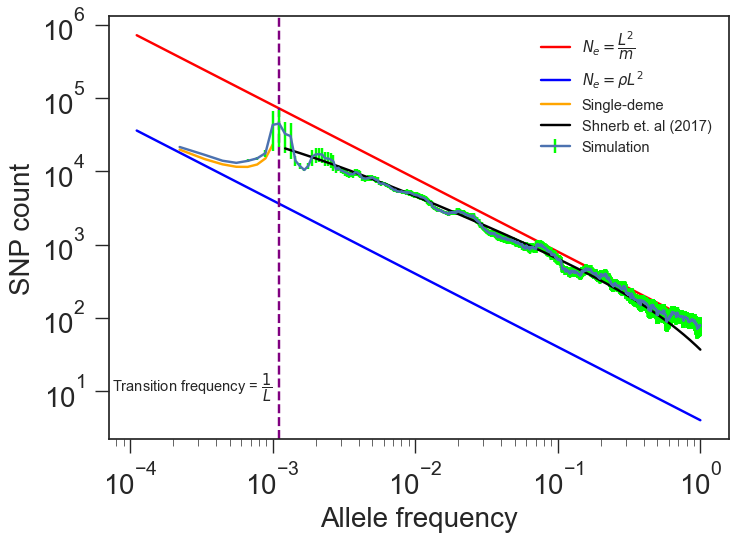

In [34]:
transition_frequency=max(Deme_density,(m*Deme_density**2))/total_sample_size
err=error_data_read.flatten()
plt.loglog(AF_xpoints, Maruyama_effective_ydata, color="red", label =r"$N_e=\dfrac{L^2}{m}$") 
plt.loglog(AF_xpoints, Maruyama_census_ydata, color="blue", label =r"$ N_e=\rho L^2 $" )
#plt.loglog(np.arange(1, total_sample_size+1)/(total_sample_size+1), smooth(afs[1:], threshold=1000, rescale=200), color="green") 
plt.axvline(transition_freq,color='purple', linestyle = '--')
plt.text(0.000075,10,r"Transition frequency = $\dfrac{1}{L}$",fontsize='10.5')
plt.loglog(scaled_x_bidirection_points[1:],bi_directional_prediction_read.flatten(),"orange", label ='Single-deme' )
plt.errorbar(AF_xpoints[1:],Simulated_data_read.flatten(), yerr=err, ecolor="lime", label = "Simulation")
plt.plot(xvals[:-1], shnerb_read.flatten(), label = 'Shnerb et. al (2017) ', color = 'black')
#plt.axvline(0.25)
plt.xlabel("Allele frequency")
plt.ylabel('SNP count')
#plt.legend([r"Predicted AFS for population of effective size $N_e=\frac{L^2}{m}$", r"Predicted AFS for population of census size $ N=\rho L^2 $", r'Transition frequency $= \frac{1}{L}$', "W-F fit","Simulated expected AFS" ], loc ="upper right")
plt.legend(prop={"size":10.5},loc="upper right")

plt.savefig("2D_afs2.pdf")